In [1]:
from google.colab import drive #import drive from google.colab
drive.mount('/content/drive') #mount google drive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#Importing required modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

In [3]:
forecast_df = pd.read_excel('/content/drive/MyDrive/final_project/EML_forecast/forecast_data.xlsx')

In [4]:
#Dropping unnamed column from  dataframe
forecast_df = forecast_df.drop(columns=['Unnamed: 0'], axis=1)
print(forecast_df)

      Year      Country   Emission  Fertlizer_consumption  Temperature
0     1961  Afghanistan  2917273.5                   0.13    11.336061
1     1962  Afghanistan  2891160.8                   0.13    11.144664
2     1963  Afghanistan  2941533.2                   0.13    12.411098
3     1964  Afghanistan  3004207.0                   0.13    10.428792
4     1965  Afghanistan  3075739.0                   0.13    11.212704
...    ...          ...        ...                    ...          ...
7864  2017     Zimbabwe  5147235.0                  15.85    21.228878
7865  2018     Zimbabwe  5237749.0                  12.22    21.909628
7866  2019     Zimbabwe  5149571.5                  12.22    22.434425
7867  2020     Zimbabwe  4687377.5                   9.59    21.785597
7868  2021     Zimbabwe  4966384.0                   9.59    21.573135

[7869 rows x 5 columns]


In [5]:
#Converting Year column to date format
forecast_df['Year'] = pd.to_datetime(forecast_df['Year'], format='%Y')
print(forecast_df)

           Year      Country   Emission  Fertlizer_consumption  Temperature
0    1961-01-01  Afghanistan  2917273.5                   0.13    11.336061
1    1962-01-01  Afghanistan  2891160.8                   0.13    11.144664
2    1963-01-01  Afghanistan  2941533.2                   0.13    12.411098
3    1964-01-01  Afghanistan  3004207.0                   0.13    10.428792
4    1965-01-01  Afghanistan  3075739.0                   0.13    11.212704
...         ...          ...        ...                    ...          ...
7864 2017-01-01     Zimbabwe  5147235.0                  15.85    21.228878
7865 2018-01-01     Zimbabwe  5237749.0                  12.22    21.909628
7866 2019-01-01     Zimbabwe  5149571.5                  12.22    22.434425
7867 2020-01-01     Zimbabwe  4687377.5                   9.59    21.785597
7868 2021-01-01     Zimbabwe  4966384.0                   9.59    21.573135

[7869 rows x 5 columns]


In [6]:
#Removing all the entries where the Country name is World
forecast_df = forecast_df[forecast_df['Country']!='World']

In [7]:
#Creating a new dataframe group by Year and taking the average of NO2 emission,
#Fertilizer counsumption and Temerature
corr_df = forecast_df.groupby('Year')[['Emission', 'Fertlizer_consumption',
                                          'Temperature']].mean()
print(corr_df)

                Emission  Fertlizer_consumption  Temperature
Year                                                        
1961-01-01  8.489050e+06              14.736211    19.195658
1962-01-01  8.757632e+06              15.680742    19.009852
1963-01-01  9.042756e+06              16.729219    19.045872
1964-01-01  9.387130e+06              17.431719    18.986813
1965-01-01  9.769996e+06              18.166797    18.890422
...                  ...                    ...          ...
2017-01-01  1.840855e+07              52.722031    20.343383
2018-01-01  1.829722e+07              51.806641    20.358923
2019-01-01  1.802809e+07              50.519258    20.509540
2020-01-01  1.808556e+07              53.520234    20.517973
2021-01-01  1.833325e+07              51.773203    20.404902

[61 rows x 3 columns]


In [8]:
#Resetting the index to transfrom Year as column
corr_df = corr_df.reset_index()
#Dropping the Year column for normalizing the data
corr_df_filter = corr_df.drop(columns = ['Year'], axis=1)

In [9]:
#Normalising data using MinMaxScaler and creating a new normalised datafraame
scaler = StandardScaler()
corr_df_norm = pd.DataFrame(scaler.fit_transform(corr_df_filter), columns = corr_df_filter.columns)
print(corr_df_norm)

    Emission  Fertlizer_consumption  Temperature
0  -2.134234              -2.360820    -0.838553
1  -2.041978              -2.277801    -1.227900
2  -1.944039              -2.185647    -1.152421
3  -1.825748              -2.123901    -1.276177
4  -1.694236              -2.059293    -1.478160
..       ...                    ...          ...
56  1.273065               0.977896     1.566445
57  1.234821               0.897439     1.599009
58  1.142378               0.784286     1.914618
59  1.162120               1.048053     1.932289
60  1.247199               0.894500     1.695355

[61 rows x 3 columns]


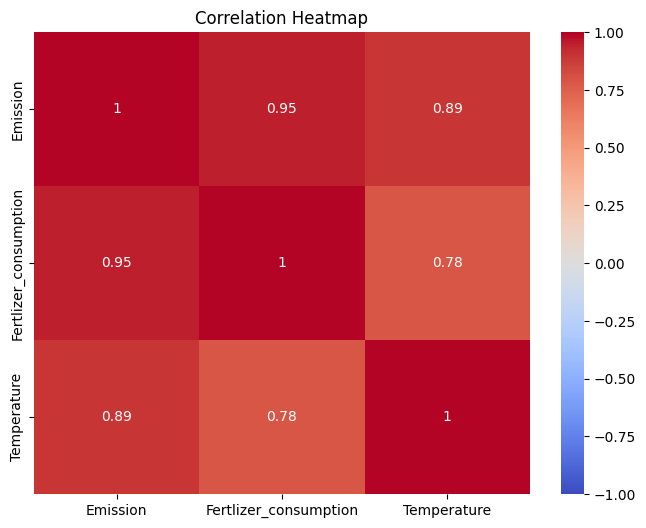

In [10]:
#Creating a correlation heatmap to explain the correlation between variables
corr_matrix = corr_df_norm.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()

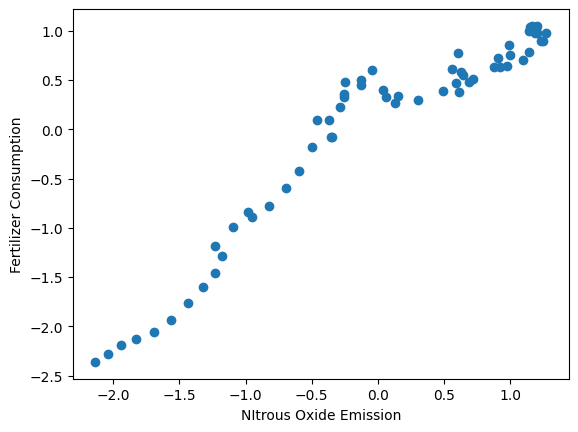

In [13]:
#Creating a scatter plot to show the correlation between Nitrous oxide emission
#and Fertilizer consumption
plt.figure()
plt.scatter(x=corr_df_norm['Emission'], y=corr_df_norm['Fertlizer_consumption'])
plt.xlabel("NItrous Oxide Emission")
plt.ylabel("Fertilizer Consumption")
plt.show()

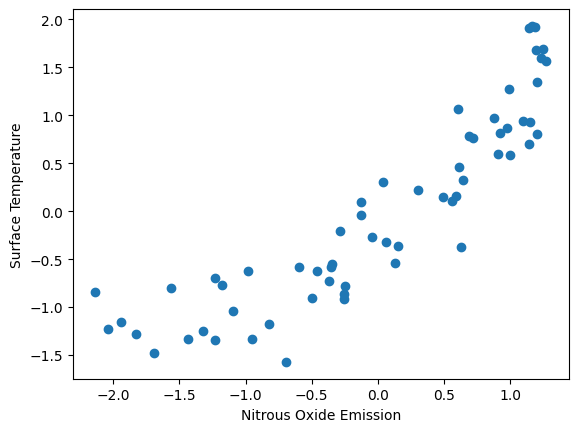

In [14]:
#Plotting a scatter plot to show the correlation between Nitrous Oxide emission
#and temperature
plt.figure()
plt.scatter(x=corr_df_norm['Emission'], y=corr_df_norm['Temperature'])
plt.xlabel("Nitrous Oxide Emission")
plt.ylabel("Surface Temperature")
plt.show()

In [16]:
#Creating a dataframe group by country and taking the average of Nitrous oxide
#emission, fertilizer consumption and temperature over the years
cluster_df = forecast_df.groupby('Country')[['Emission', 'Fertlizer_consumption', 'Temperature']].mean()
cluster_df = cluster_df.reset_index()
print(cluster_df)

         Country      Emission  Fertlizer_consumption  Temperature
0    Afghanistan  3.396077e+06               3.701311    12.139568
1        Albania  1.058664e+06              50.029344    12.347506
2        Algeria  4.612337e+06               6.541475    23.190772
3         Angola  1.213562e+07               2.046066    21.869676
4      Argentina  3.596698e+07              11.289098    14.537532
..           ...           ...                    ...          ...
123    Venezuela  9.408217e+06              41.347377    25.164835
124      Vietnam  1.057226e+07              78.833279    23.589646
125        Yemen  2.686446e+06               6.472459    25.158911
126       Zambia  9.356317e+06              17.315574    21.715711
127     Zimbabwe  4.793365e+06              20.674590    21.209186

[128 rows x 4 columns]


In [17]:
#Normalising the values of Cluster_df using standard scaler
scaler = StandardScaler()
cluster_df[['Emission', 'Fertlizer_consumption', 'Temperature']] = scaler.fit_transform(cluster_df[['Emission', 'Fertlizer_consumption', 'Temperature']])
print(cluster_df)

         Country  Emission  Fertlizer_consumption  Temperature
0    Afghanistan -0.298807              -0.871955    -1.000965
1        Albania -0.360581               0.194047    -0.973051
2        Algeria -0.266663              -0.806603     0.482601
3         Angola -0.067834              -0.910042     0.305251
4      Argentina  0.561991              -0.697361    -0.679051
..           ...       ...                    ...          ...
123    Venezuela -0.139915              -0.005724     0.747609
124      Vietnam -0.109151               0.856822     0.536148
125        Yemen -0.317561              -0.808192     0.746814
126       Zambia -0.141287              -0.558693     0.284582
127     Zimbabwe -0.261879              -0.481402     0.216584

[128 rows x 4 columns]


In [18]:
#Creating a new dataframe with only the normalised values for clustering
norm_cluster_df = cluster_df[['Emission', 'Fertlizer_consumption', 'Temperature']]

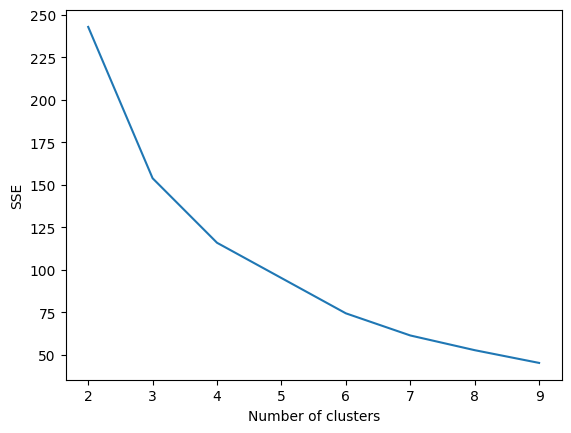

In [19]:
#Calculating the optimal number of clusters using elbow method
sse = []
for i in range(2,10):
  model = KMeans(n_clusters=i, random_state=42, n_init=10)
  model.fit(norm_cluster_df)
  sse.append(model.inertia_)

plt.figure()
plt.plot(range(2,10), sse)
plt.xlabel("Number of clusters")
plt.ylabel("SSE")
plt.show()

In [20]:
#Calcualating Silhouette score to find the optimal number of clusters
for i in range(2,10):
  model = KMeans(n_clusters=i,n_init=42, random_state=42)
  labels = model.fit_predict(norm_cluster_df)
  s_avg = silhouette_score(norm_cluster_df, labels)
  print("cluster :", i)
  print("score :", s_avg)

cluster : 2
score : 0.5002508189221149
cluster : 3
score : 0.501372742957052
cluster : 4
score : 0.4874652595201725
cluster : 5
score : 0.4442226742258525
cluster : 6
score : 0.4657235491024876
cluster : 7
score : 0.43723543416630617
cluster : 8
score : 0.43640302778632867
cluster : 9
score : 0.37100688675192783


In [21]:
#Applying KMeans clustering algorithm with number of clusters equal to 3
model = KMeans(n_clusters=3, n_init=42, random_state=42)
labels = model.fit_predict(norm_cluster_df)

# Create a dataframe with cluster labels
country_labels = pd.DataFrame({'Country': cluster_df['Country'], 'Cluster': labels})

In [22]:
#Merging the actual forecast_df with country_labels by Country column
cluster_forecast_df = pd.merge(forecast_df, country_labels, on=('Country'))
print(cluster_forecast_df)

           Year      Country   Emission  Fertlizer_consumption  Temperature  \
0    1961-01-01  Afghanistan  2917273.5                   0.13    11.336061   
1    1962-01-01  Afghanistan  2891160.8                   0.13    11.144664   
2    1963-01-01  Afghanistan  2941533.2                   0.13    12.411098   
3    1964-01-01  Afghanistan  3004207.0                   0.13    10.428792   
4    1965-01-01  Afghanistan  3075739.0                   0.13    11.212704   
...         ...          ...        ...                    ...          ...   
7803 2017-01-01     Zimbabwe  5147235.0                  15.85    21.228878   
7804 2018-01-01     Zimbabwe  5237749.0                  12.22    21.909628   
7805 2019-01-01     Zimbabwe  5149571.5                  12.22    22.434425   
7806 2020-01-01     Zimbabwe  4687377.5                   9.59    21.785597   
7807 2021-01-01     Zimbabwe  4966384.0                   9.59    21.573135   

      Cluster  
0           0  
1           0  
2  

In [23]:
#Ctreating the new dataframe with the newly clustered daatframe by Country and Cluster
cluster_grouped_df = cluster_forecast_df.groupby(['Country', 'Cluster'])[['Emission', 'Fertlizer_consumption', 'Temperature']].mean()
cluster_grouped_df = cluster_grouped_df.reset_index()


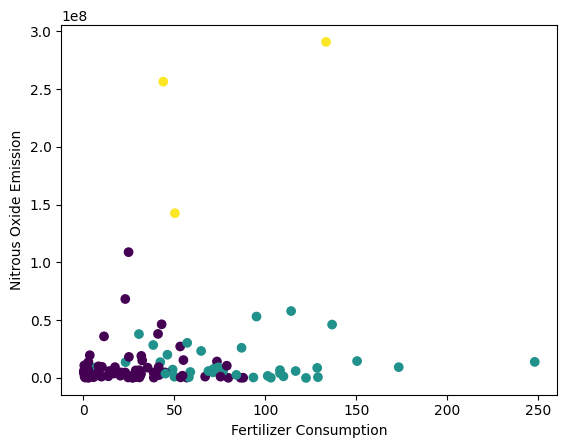

In [25]:
#Plotting the scatter plot to show the cluster distribution
plt.figure()
plt.scatter(x=cluster_grouped_df['Fertlizer_consumption'], y=cluster_grouped_df['Emission'], c=cluster_grouped_df["Cluster"])
plt.xlabel("Fertilizer Consumption")
plt.ylabel("Nitrous Oxide Emission")
plt.show()

In [ ]:
cluster_grouped_df = cluster_grouped_df.reset_index()

In [26]:
#Creating seperate dataframe for each of the clusters
cluster0_df = cluster_forecast_df[cluster_forecast_df['Cluster']==0]
cluster1_df = cluster_forecast_df[cluster_forecast_df['Cluster']==1]
cluster2_df = cluster_forecast_df[cluster_forecast_df['Cluster']==2]

In [27]:
#Grouping each of the cluster dataframe by Year
cluster0_grouped_df = cluster0_df.groupby(['Year'])[['Emission', 'Fertlizer_consumption', 'Temperature']].mean()
cluster1_grouped_df = cluster1_df.groupby(['Year'])[['Emission', 'Fertlizer_consumption', 'Temperature']].mean()
cluster2_grouped_df = cluster2_df.groupby(['Year'])[['Emission', 'Fertlizer_consumption', 'Temperature']].mean()


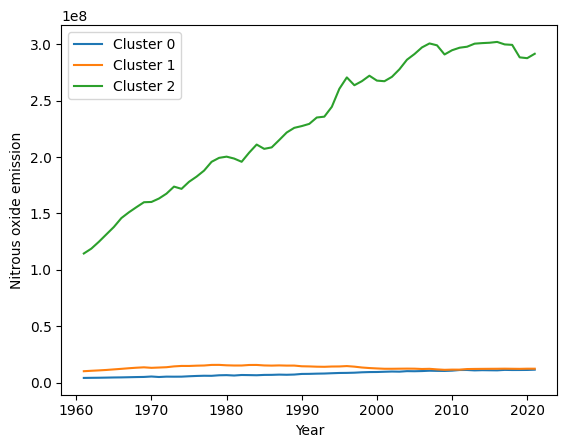

In [28]:
#Creating a line plot to show the trend in nitrous oxide Emission for each cluster
#over the years
plt.figure()
plt.plot(cluster0_grouped_df.index, cluster0_grouped_df['Emission'], label='Cluster 0')
plt.plot(cluster1_grouped_df.index, cluster1_grouped_df['Emission'], label='Cluster 1')
plt.plot(cluster2_grouped_df.index, cluster2_grouped_df['Emission'], label='Cluster 2')
plt.xlabel("Year")
plt.ylabel("Nitrous oxide emission")
plt.legend()
plt.show()

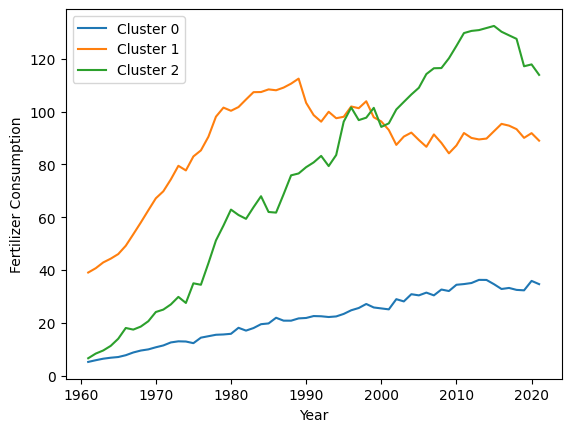

In [30]:
#Creating a lineplot to show the trend in Fertilizer Consumption for each cluster
#over the years
plt.figure()
plt.plot(cluster0_grouped_df.index, cluster0_grouped_df['Fertlizer_consumption'], label='Cluster 0')
plt.plot(cluster1_grouped_df.index, cluster1_grouped_df['Fertlizer_consumption'], label='Cluster 1')
plt.plot(cluster2_grouped_df.index, cluster2_grouped_df['Fertlizer_consumption'], label='Cluster 2')
plt.xlabel("Year")
plt.ylabel("Fertilizer Consumption")
plt.legend()
plt.show()

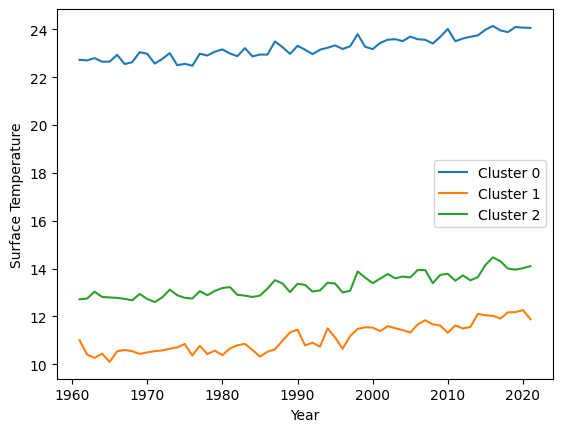

In [32]:
#Creating a line plot to show the trend in surface temperature for each cluster
#over the years
plt.figure()
plt.plot(cluster0_grouped_df.index, cluster0_grouped_df['Temperature'], label='Cluster 0')
plt.plot(cluster1_grouped_df.index, cluster1_grouped_df['Temperature'], label='Cluster 1')
plt.plot(cluster2_grouped_df.index, cluster2_grouped_df['Temperature'], label='Cluster 2')
plt.xlabel("Year")
plt.ylabel("Surface Temperature")
plt.legend()
plt.show()